In [ ]:
!pip install gtsam

In [2]:
# brief: 2D SLAM example
# date: Apr 7 2022
# author: Qingwen Zhang(Kin), Jing Dong(origin author for cpp and matlab)

# A simple 2D pose-graph SLAM
# The robot moves from x1 to x5, with odometry information between each pair. 
# the robot moves 5 each step, and makes 90 deg right turns at x3 - x5
# At x5, there is a *loop closure* between x2 is avaible
# The graph strcuture is shown:
#  
#   p-x1 - x2 - x3
#          |    |
#          x5 - x4

import numpy as np
from gtsam import *
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [3]:

# Create a factor graph container
graph = NonlinearFactorGraph()

# Add a prior on the first pose, setting it to the origin
# The prior is needed to fix/align the whole trajectory at world frame
# A prior factor consists of a mean value and a noise model (covariance matrix)
priorModel = noiseModel.Diagonal.Sigmas(np.array([1.0, 1.0, 0.1]))
graph.add(PriorFactorPose2(symbol('x', 1), Pose2(0, 0, 0), priorModel))



# odometry measurement noise model (covariance matrix)
odomModel = noiseModel.Diagonal.Sigmas(np.array([0.5, 0.5, 0.1]))


# Add odometry factors
# Create odometry (Between) factors between consecutive poses
# robot makes 90 deg right turns at x3 - x5

graph.add(BetweenFactorPose2(symbol('x', 1), symbol('x', 2), Pose2(5, 0, 0), odomModel))
graph.add(BetweenFactorPose2(symbol('x', 2), symbol('x', 3), Pose2(5, 0, -np.pi/2), odomModel))
graph.add(BetweenFactorPose2(symbol('x', 3), symbol('x', 4), Pose2(5, 0, -np.pi/2), odomModel))
graph.add(BetweenFactorPose2(symbol('x', 4), symbol('x', 5), Pose2(5, 0, -np.pi/2), odomModel))

# loop closure measurement noise model
loopModel = noiseModel.Diagonal.Sigmas(np.array([0.5, 0.5, 0.1]))

# Add the loop closure constraint
graph.add(BetweenFactorPose2(symbol('x', 5), symbol('x', 2), Pose2(5, 0, -np.pi/2), loopModel))

# print factor graph
graph.print('\nFactor Graph:\n')

# initial varible values for the optimization
# add random noise from ground truth values
initials = Values()
initials.insert(symbol('x', 1), Pose2(0.2, -0.3, 0.2))
initials.insert(symbol('x', 2), Pose2(5.1, 0.3, -0.1))
initials.insert(symbol('x', 3), Pose2(9.9, -0.1, -np.pi/2 - 0.2))
initials.insert(symbol('x', 4), Pose2(10.2, -5.0, -np.pi + 0.1))
initials.insert(symbol('x', 5), Pose2(5.1, -5.1, np.pi/2 - 0.1))

# print initial values
initials.print('\nInitial Values:\n')


Factor Graph:
size: 6

Factor 0: PriorFactor on x1
  prior mean:  (0, 0, 0)
  noise model: diagonal sigmas[1; 1; 0.1];

Factor 1: BetweenFactor(x1,x2)
  measured:  (5, 0, 0)
  noise model: diagonal sigmas[0.5; 0.5; 0.1];

Factor 2: BetweenFactor(x2,x3)
  measured:  (5, 0, -1.57079633)
  noise model: diagonal sigmas[0.5; 0.5; 0.1];

Factor 3: BetweenFactor(x3,x4)
  measured:  (5, 0, -1.57079633)
  noise model: diagonal sigmas[0.5; 0.5; 0.1];

Factor 4: BetweenFactor(x4,x5)
  measured:  (5, 0, -1.57079633)
  noise model: diagonal sigmas[0.5; 0.5; 0.1];

Factor 5: BetweenFactor(x5,x2)
  measured:  (5, 0, -1.57079633)
  noise model: diagonal sigmas[0.5; 0.5; 0.1];


Initial Values:

Values with 5 values:
Value x1: (gtsam::Pose2)
(0.2, -0.3, 0.2)

Value x2: (gtsam::Pose2)
(5.1, 0.3, -0.1)

Value x3: (gtsam::Pose2)
(9.9, -0.1, -1.77079633)

Value x4: (gtsam::Pose2)
(10.2, -5, -3.04159265)

Value x5: (gtsam::Pose2)
(5.1, -5.1, 1.47079633)



In [4]:
# Use Gauss-Newton method optimizes the initial values
parameters = GaussNewtonParams()
# print(parameters)
# print per iteration
parameters.setVerbosity('ERROR')
  
# optimize!
# print(GaussNewtonOptimizer)
optimizer = GaussNewtonOptimizer(graph, initials, parameters)
results = optimizer.optimize()
# results = optimizer.optimizeSafely()
# print final values
results.print('Final Result:\n')

Final Result:

Values with 5 values:
Value x1: (gtsam::Pose2)
(-8.7469579581e-19, 4.93643281416e-19, 9.56478601834e-20)
Initial error: 18.510326

Value x2: (gtsam::Pose2)
(5, 1.09529340269e-18, 1.66613556296e-19)
newError: 0.122934358
errorThreshold: 0.122934358 > 0
absoluteDecrease: 18.3873916591 >= 1e-05
relativeDecrease: 0.993358606565 >= 1e-05
newError: 8.85829965244e-06
errorThreshold: 8.85829965244e-06 > 0
absoluteDecrease: 0.12292549938 >= 1e-05
relativeDecrease: 0.999927942848 >= 1e-05
newError: 3.68234838128e-15
errorThreshold: 3.68234838128e-15 > 0
absoluteDecrease: 8.85829964875e-06 < 1e-05
relativeDecrease: 0.999999999584 >= 1e-05
converged
errorThreshold: 3.68234838128e-15 <? 0
absoluteDecrease: 8.85829964875e-06 <? 1e-05
relativeDecrease: 0.999999999584 <? 1e-05
iterations: 3 >? 100

Value x3: (gtsam::Pose2)
(10.0000000015, -4.40576430636e-09, -1.5707963267)

Value x4: (gtsam::Pose2)
(10.0000000114, -5.00000003139, 3.14159265352)

Value x5: (gtsam::Pose2)
(4.99999999784, 

In [5]:
# Calculate marginal covariances for all poses
marginals = Marginals(graph, results)

# print marginal covariances
for i in range(1,6):
    print('cov ',i,'\n\r',marginals.marginalCovariance(symbol('x', i)))


cov  1 
 [[ 1.00000000e+00 -1.97077547e-17 -8.08957841e-17]
 [-1.97077547e-17  1.00000000e+00 -1.42108547e-16]
 [-8.08957841e-17 -1.42108547e-16  1.00000000e-02]]
cov  2 
 [[ 1.25000000e+00 -5.36380446e-16 -2.01005411e-16]
 [-5.36380446e-16  1.50000000e+00  5.00000000e-02]
 [-2.01005411e-16  5.00000000e-02  2.00000000e-02]]
cov  3 
 [[ 2.70000000e+00 -8.21534209e-10 -1.55000000e-01]
 [-8.21534197e-10  1.45000000e+00 -4.99999991e-03]
 [-1.55000000e-01 -4.99999991e-03  2.65000000e-02]]
cov  4 
 [[ 2.11250001  0.80000001 -0.12      ]
 [ 0.80000001  2.8        -0.17      ]
 [-0.12       -0.17        0.028     ]]
cov  5 
 [[ 1.7    -0.225   0.045 ]
 [-0.225   2.0625 -0.1275]
 [ 0.045  -0.1275  0.0265]]


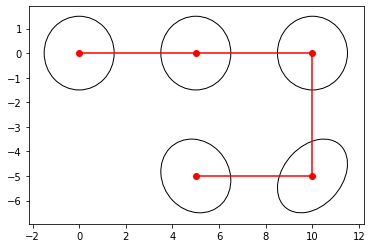

In [7]:
xs,ys = [],[]
# create a new figure
plt.figure()
ax = plt.gca()

for i in range(1,6):
    x = results.atPose2(symbol('x', i)).x()
    y = results.atPose2(symbol('x', i)).y()
    theta = results.atPose2(symbol('x', i)).theta()
    xs.append(x)
    ys.append(y)


    # https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
    cov = marginals.marginalCovariance(symbol('x', i))
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    ellipse = Ellipse((x, y),
    width=ell_radius_x * 3,
    height=ell_radius_y * 3,
    angle=45,
    edgecolor='black', facecolor='none'
    )

    ellipse.set_transform(ax.transData) #
    ax.add_patch(ellipse)

# ax.set_aspect(1.0)  # make aspect ratio square
ax.plot(xs,ys, 'ro-')
plt.show()